## PCA (1/4)
Download the MNIST dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds

# Download data
mnist_data = tfds.load("mnist")
dataset = tfds.as_numpy(mnist_data["train"].batch(60000))

# Wrangle into features/labels
sample = next(iter(dataset))
images = sample['image']
labels = sample['label']

assert images.shape == (60000, 28, 28, 1)
assert labels.shape == (60000,)

2022-05-02 14:31:27.576134: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2022-05-02 14:31:33.762395: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## PCA (2/4)
Plot the sorted eigenvectors of the covariance matrix.

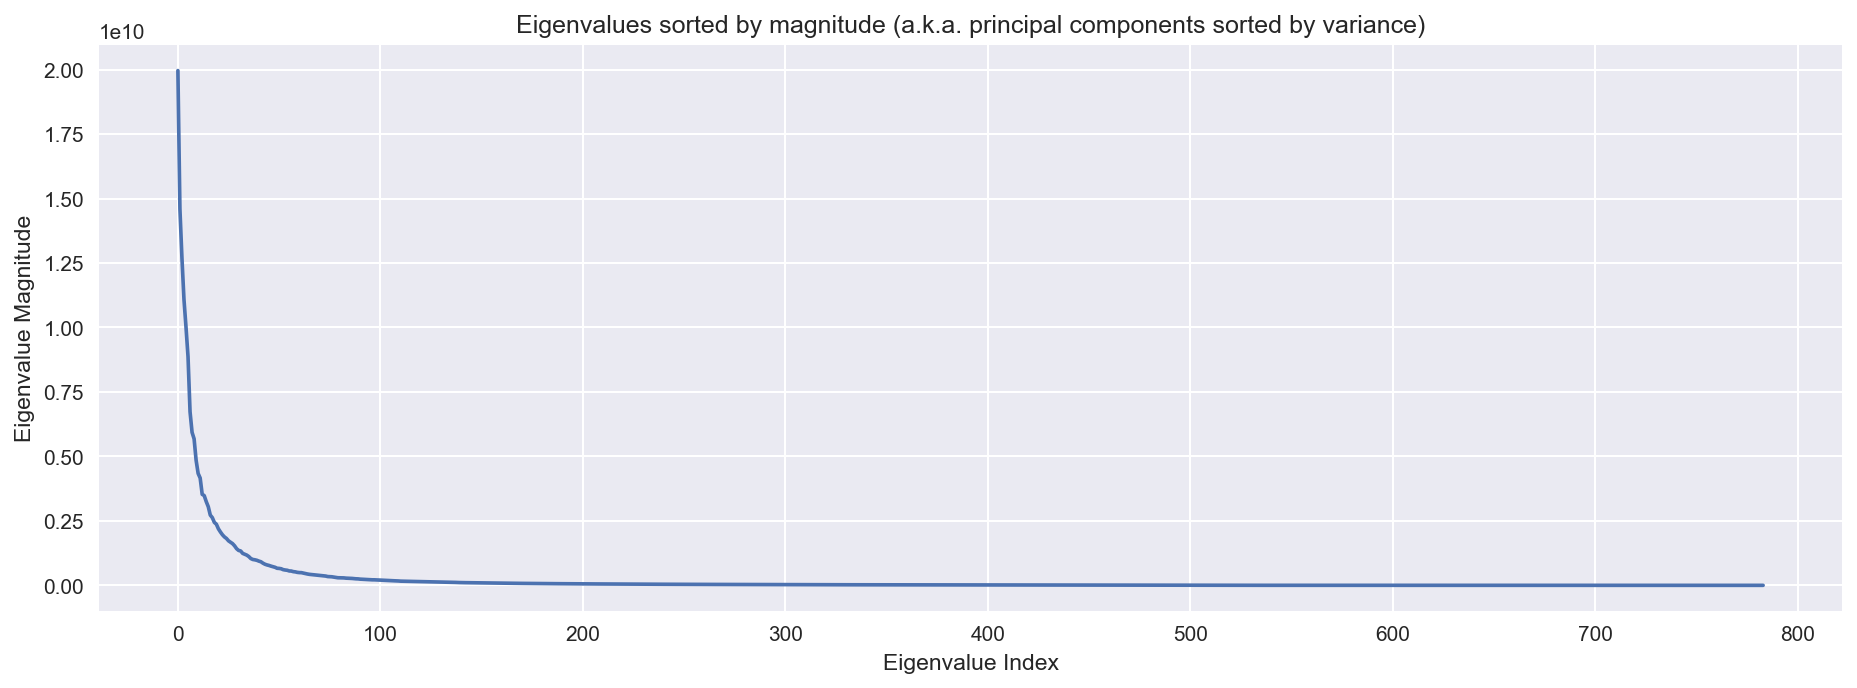

In [2]:
# Flatten each of the 60,000 28x28 images to a 784-component vector
X = images.reshape(images.shape[0], -1)

# Center the data on the origin
mu = X.mean(axis=0)
X = X - mu

# Calculate the eigendecomposition of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(X.T @ X)

# Sort eigenvectors by their eigenvalues -> ordered principal components
descending = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[descending]
eigenvectors = eigenvectors[:,descending]

# Cast complex eigens to reals, discarding the imaginary parts
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

plt.style.use('seaborn')
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(eigenvalues)

plt.title("Eigenvalues sorted by magnitude (a.k.a. principal components sorted by variance)")
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.show()

## PCA (3/4)
Visualize and describe the top 10 principal components (as images).

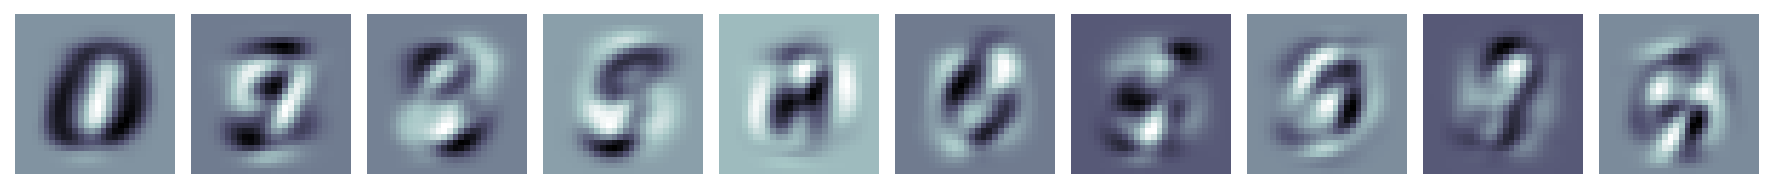

In [3]:
# Visualize the top principal components
fig, axes = plt.subplots(1, 10, figsize=(15, 5), dpi=150,
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenvectors[:,i].reshape(28, 28), cmap='bone')

**Description**: These top 10 principal components (PC) represent the 10 axes through the 784-dimensional PCA space that represent the *highest variance*. Each PC shows its variance (represented as the *contrast* between neighboring pixels) in the center of its image embedding, which aligns with the fact that each written digit in the MNIST dataset is roughly centered in its 28x28 image. Some of the PCs look like specific digits; this resemblance can be explained by thinking about *where the pixels vary* among the digits.

## PCA (4/4)
Reconstruct images using K principal components.

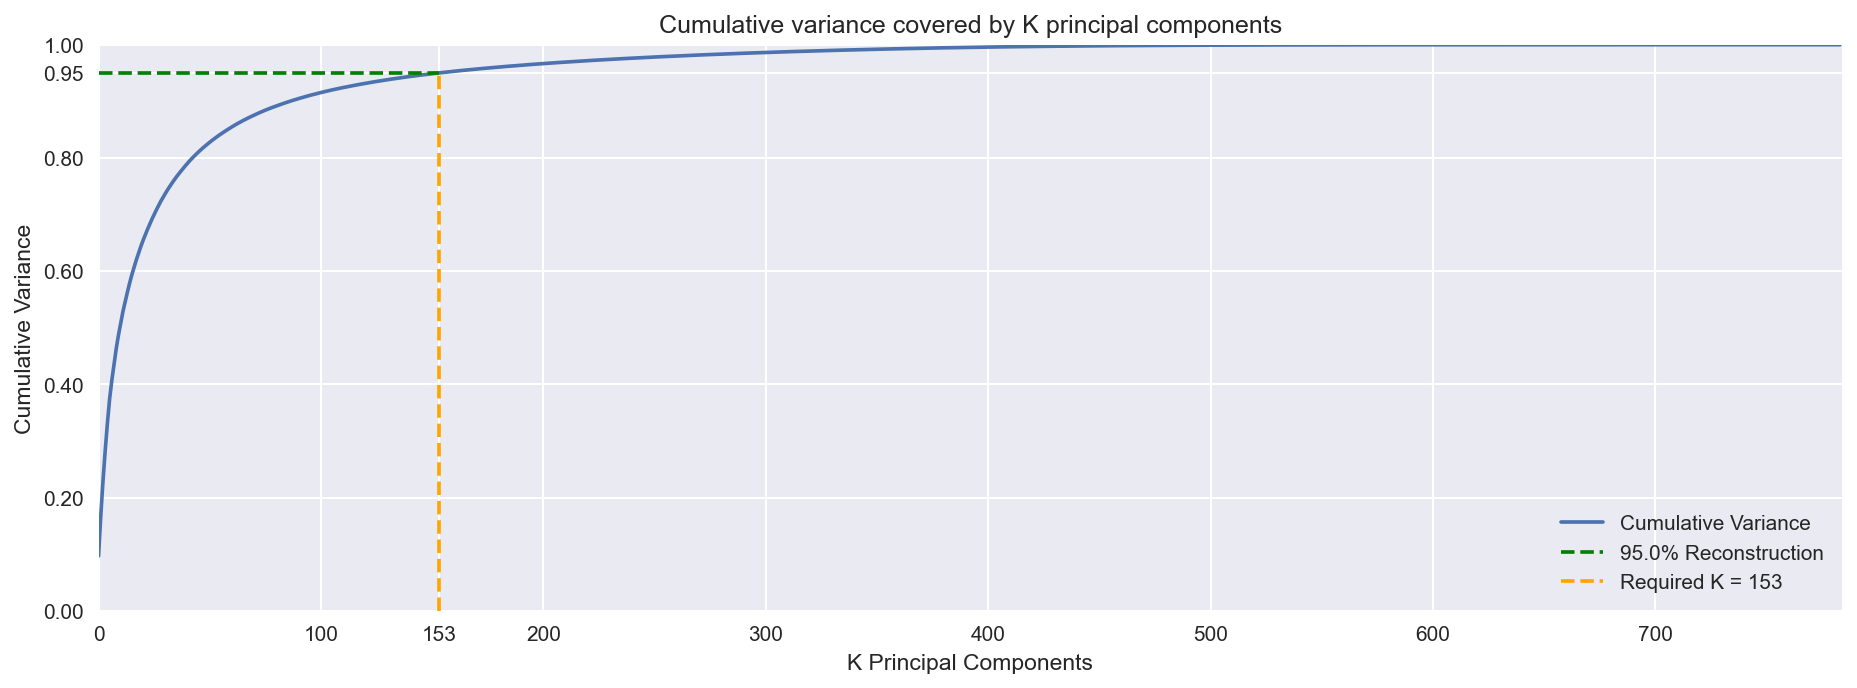

In [4]:
# Find the required K for a specific threshold of reconstruction
cumulative_variance = [(eigenvalues[:i] / eigenvalues.sum()).sum() for i in range(1, eigenvalues.shape[0] + 1)]
cumulative_variance = np.array(cumulative_variance)

threshold = 0.95 # <-- Change the reconstruction threshold here. Seriously, try it!
K = cumulative_variance[cumulative_variance < threshold].argmax() + 1

# Plot cumulative variance
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(cumulative_variance, label='Cumulative Variance')
plt.hlines(threshold, 0, K, colors='green', linestyles='--', label=f'{threshold * 100}% Reconstruction')
plt.vlines(K, 0, threshold, colors='orange', linestyles='--', label=f'Required K = {K}')

plt.title("Cumulative variance covered by K principal components")
plt.xlabel("K Principal Components")
plt.ylabel("Cumulative Variance")
plt.legend(loc='lower right')

plt.xticks([n for n in range(0, 800, 100)] + [K])
plt.yticks([n for n in np.arange(0, 1.2, 0.2)] + [threshold])
plt.xlim(0, 784)
plt.ylim(0, 1)
plt.show()

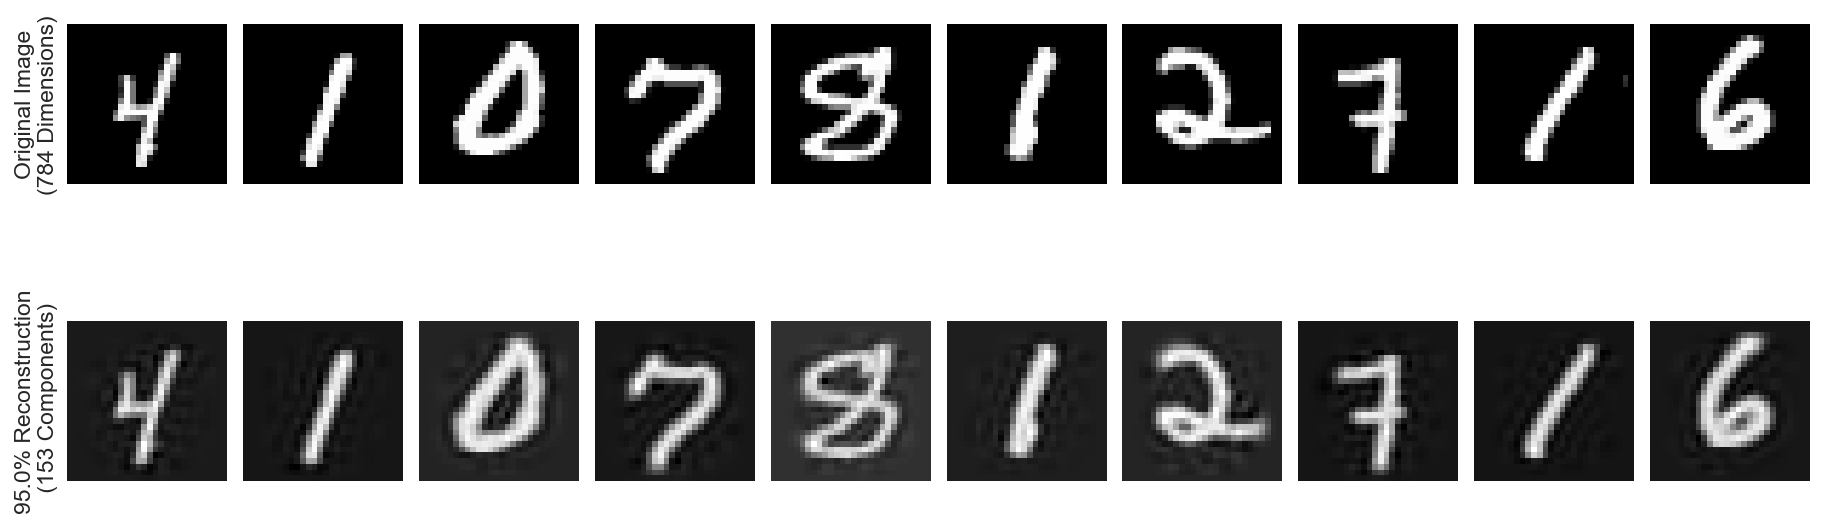

In [5]:
# Reconstruct 10 MNIST images using K principal components
projected = X @ eigenvectors[:,:K] @ eigenvectors[:,:K].T + mu
fig, ax = plt.subplots(2, 10, figsize=(15, 5), dpi=150,
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(images[i].reshape(28, 28), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(28, 28), cmap='binary_r')

ax[0, 0].set_ylabel('Original Image\n(784 Dimensions)')
ax[1, 0].set_ylabel(f'{threshold * 100}% Reconstruction\n ({K} Components)');

## Transfer Learning (1/2)
Embed Pokemon in the MNIST PCA space.

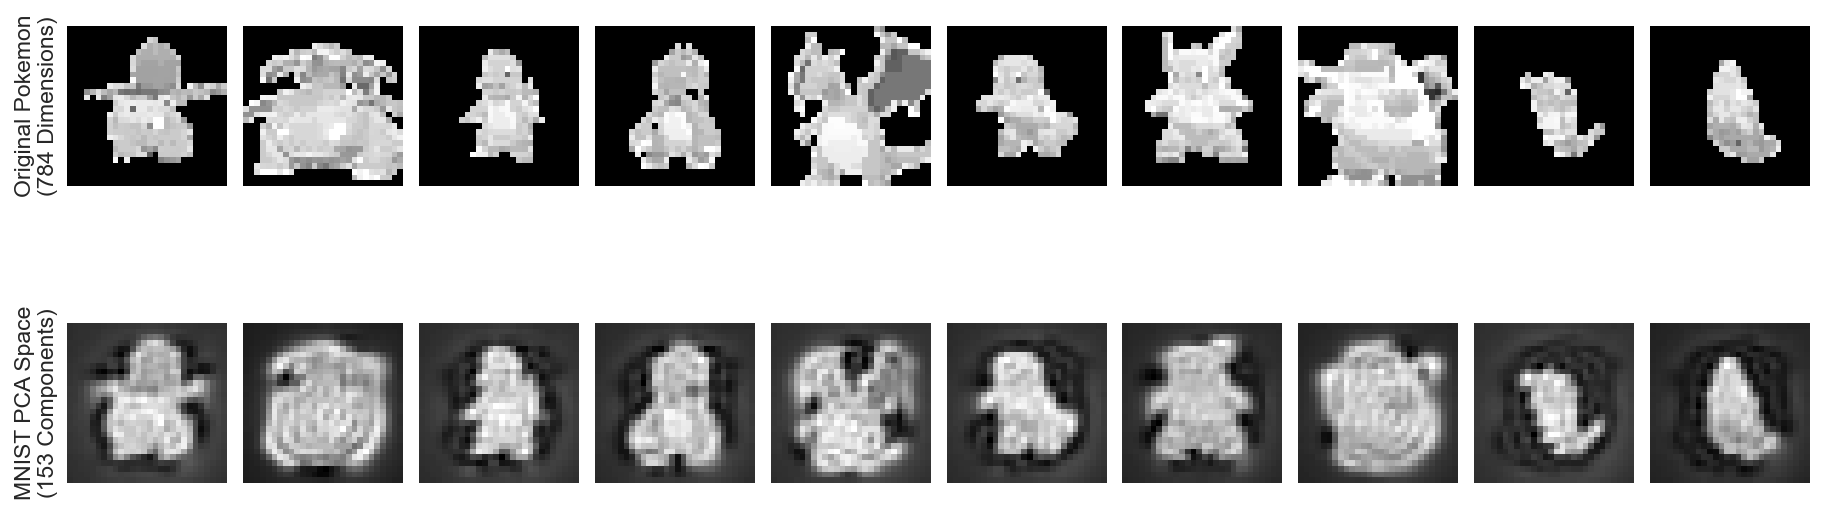

In [6]:
# Pokemon image dataset downloaded from link in README
pokeimages = pd.read_csv("./data/pokemon_mnist_images.csv").to_numpy()

# Flatten each of the 60,000 28x28 images to a 784-component vector
X_pokemon = pokeimages.reshape(pokeimages.shape[0], -1)

# Center the data on the origin
mew = X_pokemon.mean(axis=0)
X_pokemon = X_pokemon - mew

# Send Pokemon to the MNIST PCA space, then reconstruct them
projected_pokemon = X_pokemon @ eigenvectors[:,:K] @ eigenvectors[:,:K].T + mew
fig, ax = plt.subplots(2, 10, figsize=(15, 5), dpi=150,
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(pokeimages[i].reshape(28, 28), cmap='binary_r')
    ax[1, i].imshow(projected_pokemon[i].reshape(28, 28), cmap='binary_r')

ax[0, 0].set_ylabel('Original Pokemon\n(784 Dimensions)')
ax[1, 0].set_ylabel(f'MNIST PCA Space\n({K} Components)');

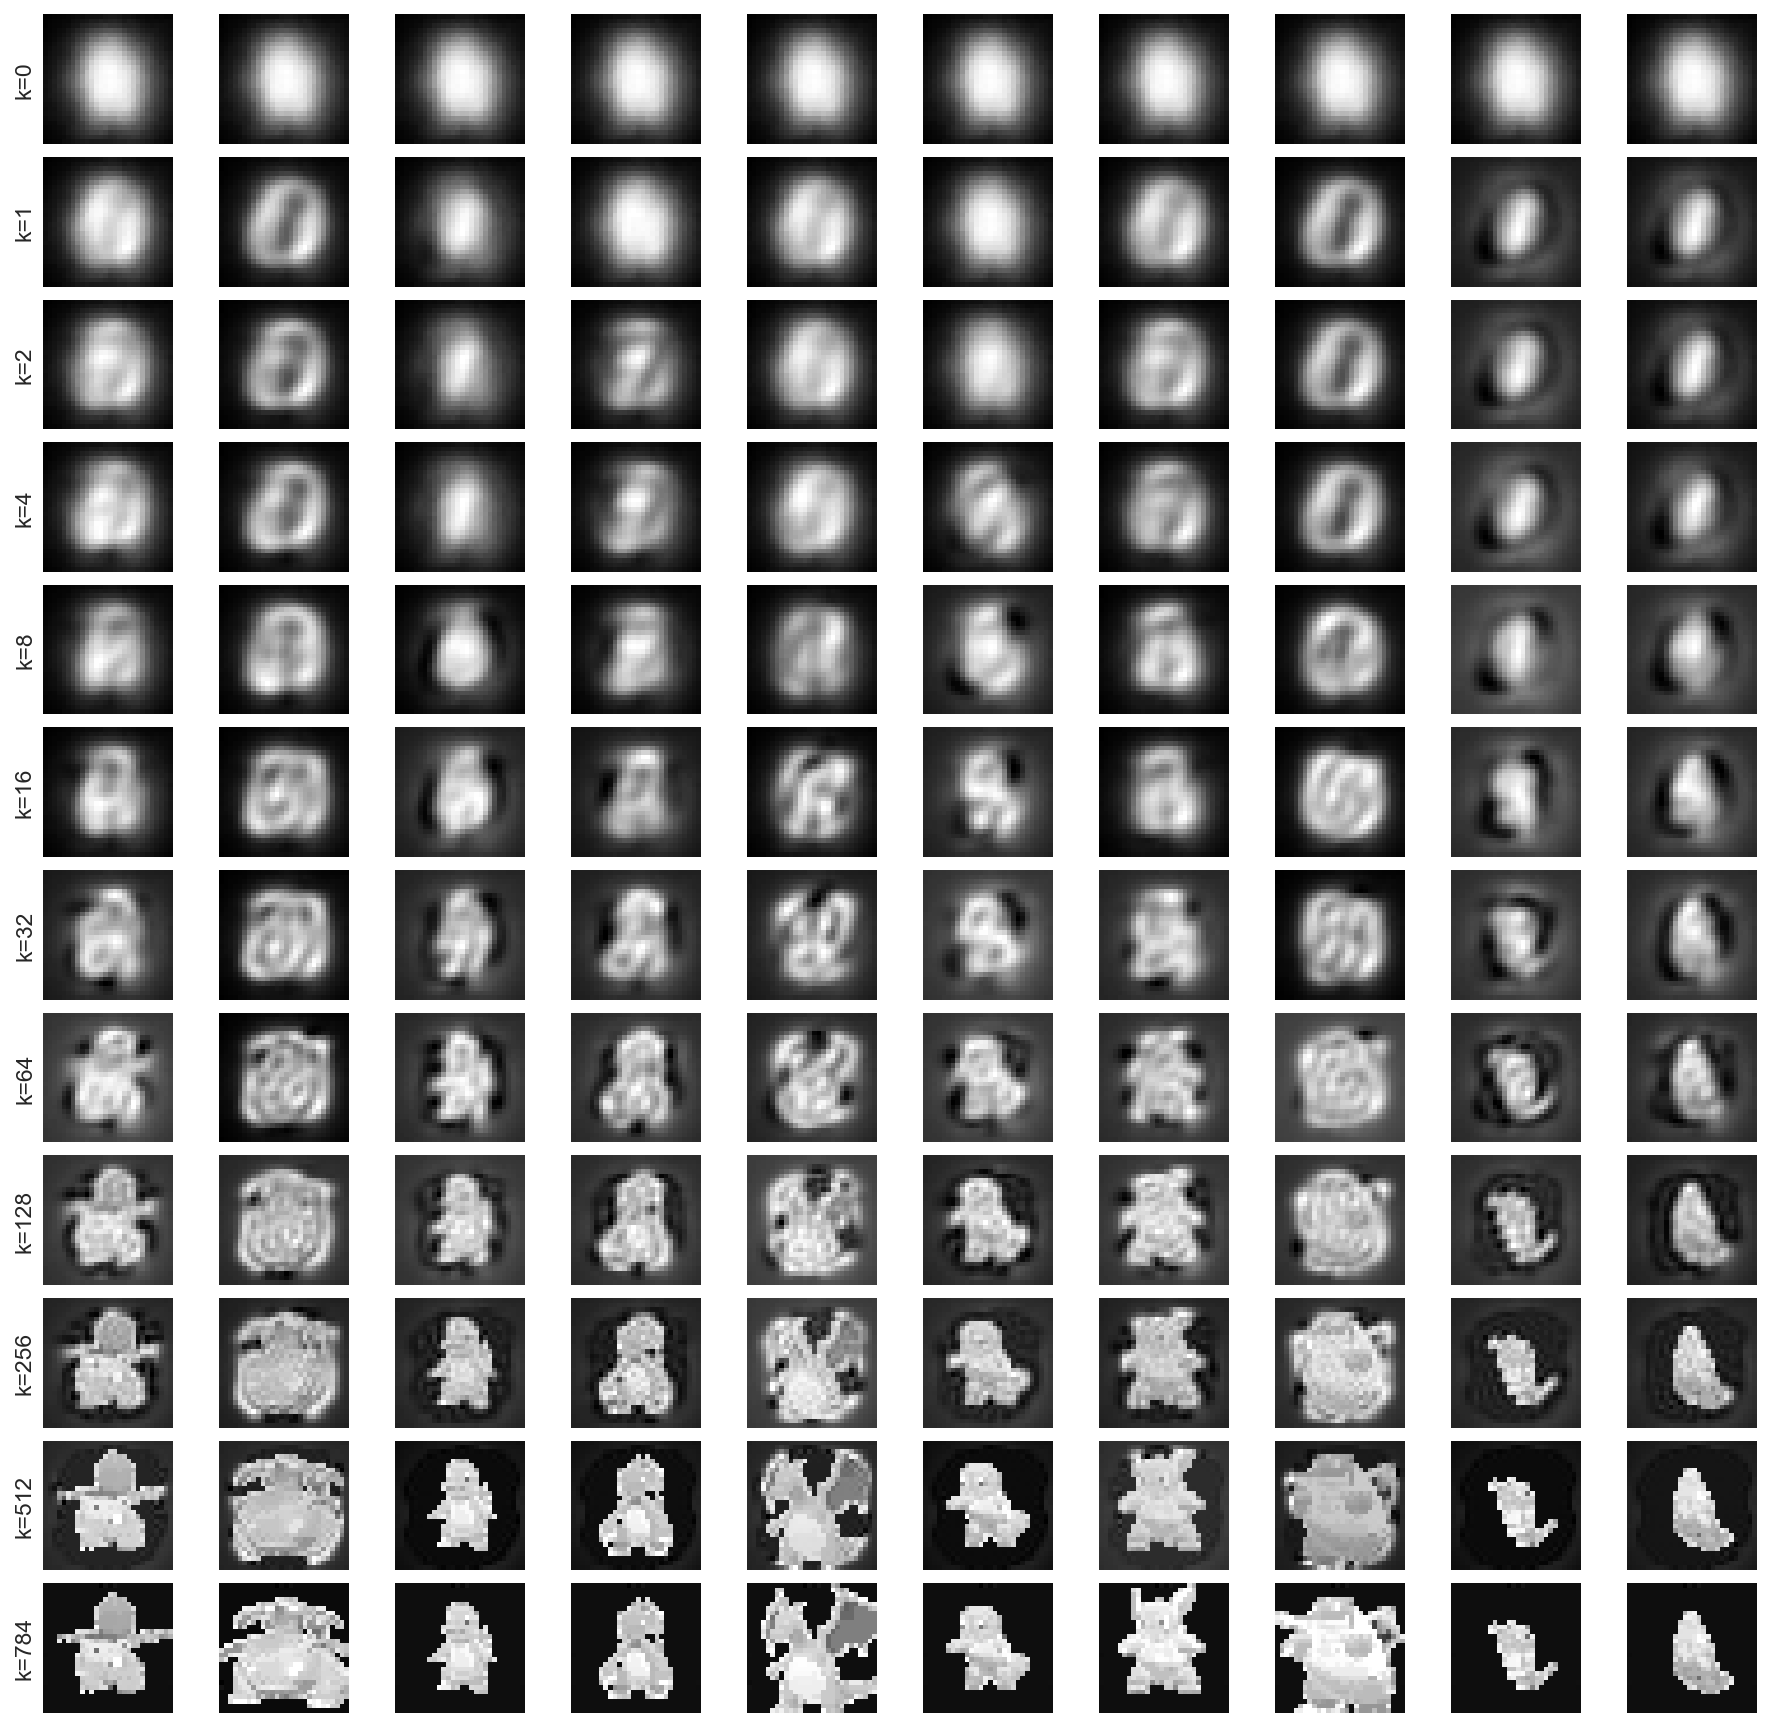

In [7]:
# Plot reconstructions with different K values
k_values = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 784]

# Prepare losses for next cell
losses_mnist = []
losses_pokemon = []

fig, ax = plt.subplots(len(k_values), 10, figsize=(15, 15), dpi=150,
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for j, k in enumerate(k_values):
    projection_mnist = X @ eigenvectors[:,:k] @ eigenvectors[:,:k].T + mu
    projection_pokemon = X_pokemon @ eigenvectors[:,:k] @ eigenvectors[:,:k].T + mew

    loss_mnist = ((X + mu - projection_mnist) ** 2).mean()
    loss_pokemon = ((X_pokemon + mew - projection_pokemon) ** 2).mean()

    losses_mnist.append(loss_mnist)
    losses_pokemon.append(loss_pokemon)

    for i in range(10):
        ax[j, i].imshow(projection_pokemon[i].reshape(28, 28), cmap='binary_r')

    ax[j, 0].set_ylabel(f'k={k}')

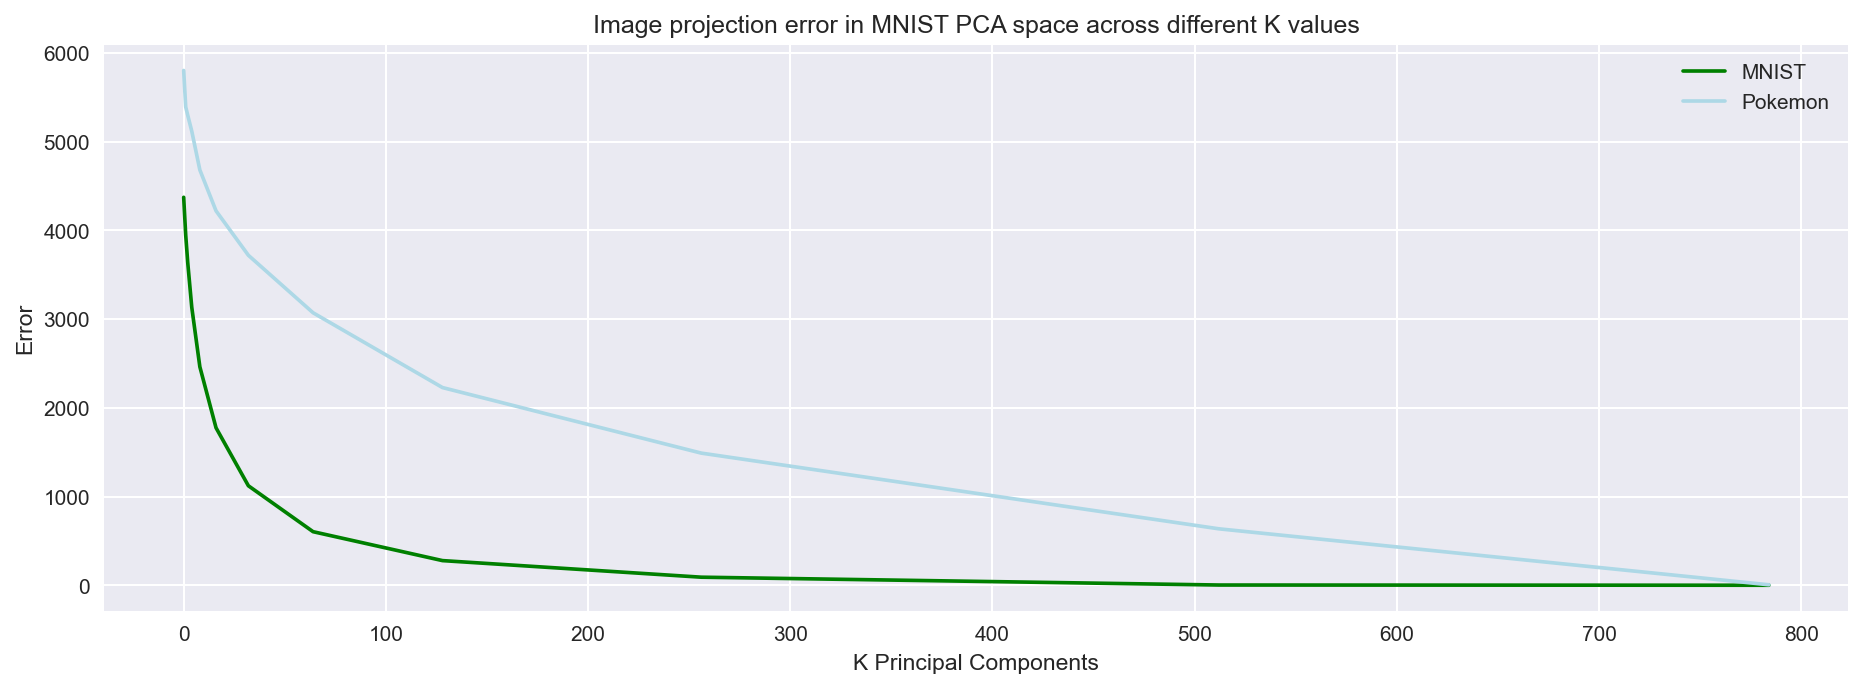

In [8]:
# Plot projection error with respect to different K values
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(k_values, losses_mnist, label='MNIST', c='green')
plt.plot(k_values, losses_pokemon, label='Pokemon', c='lightblue')

plt.title("Image projection error in MNIST PCA space across different K values")
plt.xlabel("K Principal Components")
plt.ylabel("Error")

plt.legend()
plt.show()

## Transfer Learning (2/2)
Compare MNIST PCA space embeddings of Pokemon to Pokemon PCA space embeddings.

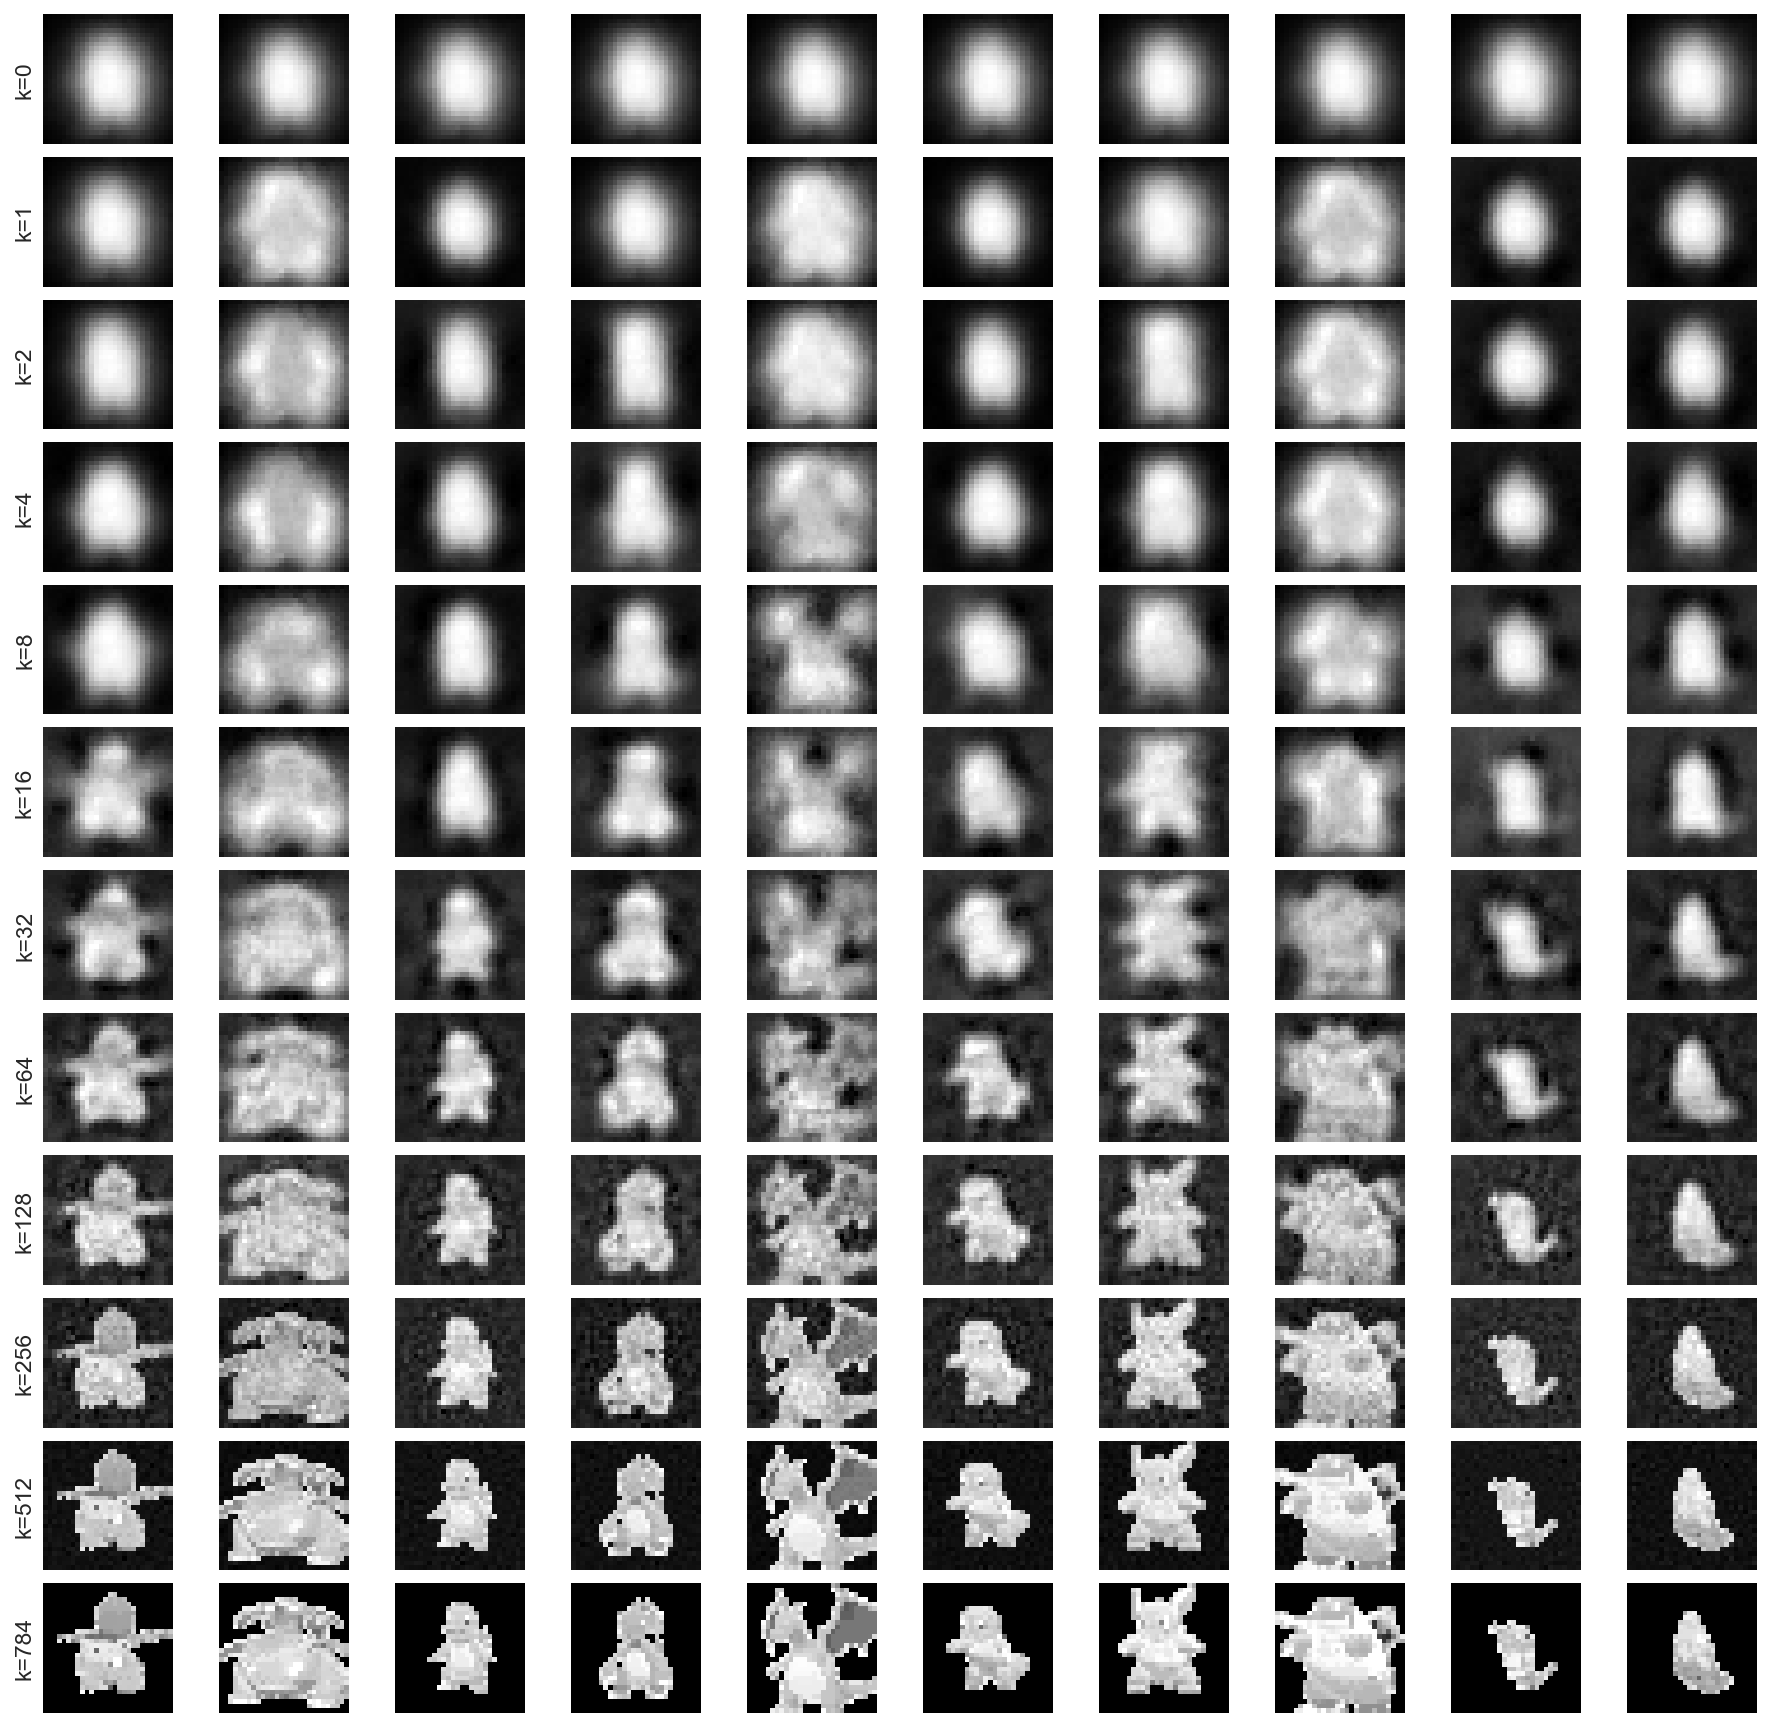

In [9]:
# Calculate the eigendecomposition of the covariance matrix
pokeeigenvalues, pokeeigenvectors = np.linalg.eig(X_pokemon.T @ X_pokemon)

# Sort eigenvectors by their eigenvalues -> ordered principal components
pokedescending = pokeeigenvalues.argsort()[::-1]
pokeeigenvalues = pokeeigenvalues[pokedescending]
pokeeigenvectors = pokeeigenvectors[:, pokedescending]

# Cast complex eigens to reals, discarding the imaginary parts
pokeeigenvalues = np.real(pokeeigenvalues)
pokeeigenvectors = np.real(pokeeigenvectors)

fig, ax = plt.subplots(len(k_values), 10, figsize=(15, 15), dpi=150,
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

pokelosses = []

for j, k in enumerate(k_values):
    projection = X_pokemon @ pokeeigenvectors[:,:k] @ pokeeigenvectors[:,:k].T + mew
    pokelosses.append(((X_pokemon + mew - projection) ** 2).mean())

    for i in range(10):
        ax[j, i].imshow(projection[i].reshape(28, 28), cmap='binary_r')

    ax[j, 0].set_ylabel(f'k={k}')

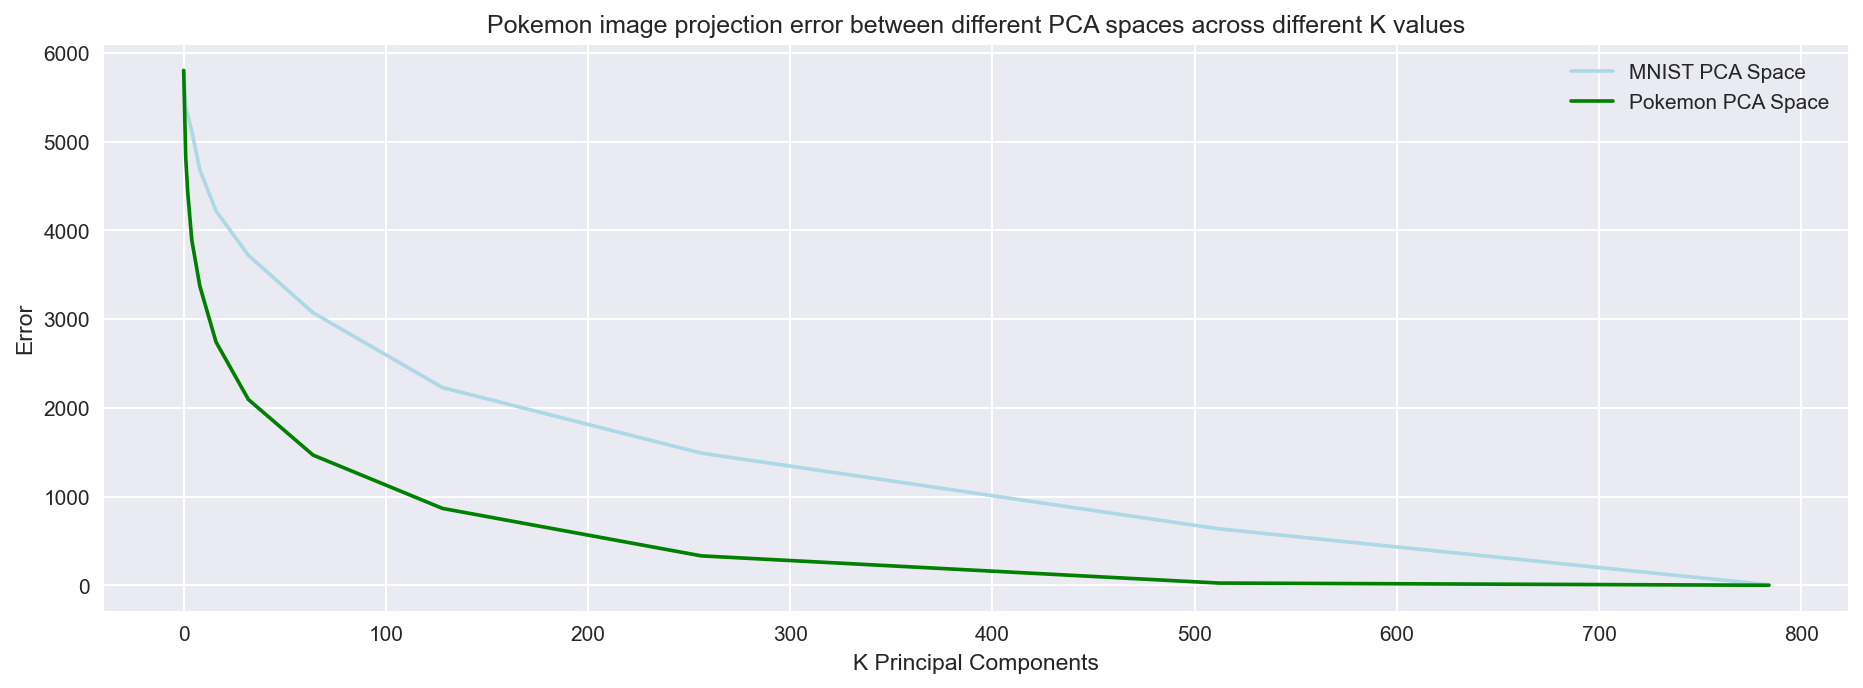

In [10]:
# Plot projection error with respect to different K values
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(k_values, losses_pokemon, label='MNIST PCA Space', c='lightblue')
plt.plot(k_values, pokelosses, label='Pokemon PCA Space', c='green')

plt.title("Pokemon image projection error between different PCA spaces across different K values")
plt.xlabel("K Principal Components")
plt.ylabel("Error")

plt.legend()
plt.show()

## Conclusion

When an image is embedded into a PCA space, the choice of space itself is *relatively trivial* at near-minimum and near-maximum values of K.

However, the magic of PCA shows itself for non-extreme values of K. There in the middle, we find that embeddings of an image are *noticeably dependent* on the PCA space. That is to say, the reconstructed image in question will be shapeshifted as a partial form of the images from which the PCA space was created. This is because the reconstruction itself is merely a linear combination of the principal components governing the PCA space of the reconstruction.

Altogether, we can see that PCA is a powerful tool not only for dimensionality reduction, but also for transfer learning, as *any image* can be reliably reconstructed in *any PCA space*.